# Answer Question 4 (Patrick)

What characteristics are predictors for changes in life expectancy in a country over time?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for now we don't have preprocessed data, so we use the raw data 
data_raw = pd.read_csv('data/processed/merged_data.csv')
data_raw.set_index(['Country','Year'], inplace=True)


In [2]:
# Income level unknown
# Delete this countries
#delcon = data_raw[(data_raw['Income Level']=='Unknown') | (data_raw['Income Level'].isnull())]['Country'].unique().tolist()
#delcon.append('Democratic People\'s Republic of Korea')
#delcon.append('Somalia')
#print(delcon)
#data = data_raw[~data_raw['Country'].isin(delcon)]
#display(data_raw[data_raw['Country'] == 'Ghana'])


# do some quick processing so we can work with it 
df_data = data_raw
df_data.drop(columns=['Last Updated: 11/14/2018', 'Data from database: World Development Indicators', 'GNI, Atlas method (current US$)'], inplace=True)
display(df_data)



Life expectancy at birth (years)  Both sexes  \
Country     Year                                                 
Afghanistan 2016                                          62.7   
            2015                                          63.2   
            2014                                          63.0   
            2013                                          62.7   
            2012                                          62.2   
            2011                                          61.7   
            2010                                          61.2   
            2009                                          60.7   
            2008                                          60.2   
            2007                                          59.6   
            2006                                          59.2   
            2005                                          58.9   
            2004                                          58.4   
            2003                                          58.0   
            2002                                          57.4   
            2001                                          56.5   
            2000                                          55.9   
Albania     2016                                          76.4   
            2015                                          76.1   
            2014                                          76.1   
            2013                                          75.7   
            2012                                          75.2   
            2011                                          75.1   
            2010                                          74.7   
            2009                                          74.4   
            2008                                          74.2   
            2007                                          74.1   
            2006                                          73.9   
            2005                                          73.5   
            2004                                          73.3   
...                                                        ...   
Zambia      2012                                          59.6   
            2011                                          58.6   
            2010                                          57.5   
            2009                                          56.0   
            2008                                          54.0   
            2007                                          51.6   
            2006                                          50.1   
            2005                                          48.8   
            2004                                          47.6   
            2003                                          46.4   
            2002                                          45.7   
            2001                                          45.0   
            2000                                          44.4   
Zimbabwe    2016                                          61.4   
            2015                                          60.8   
            2014                                          59.9   
            2013                                          58.6   
            2012                                          57.3   
            2011                                          55.5   
            2010                                          52.9   
            2009                                          50.6   
            2008                                          48.9   
            2007                                          47.4   
            2006                                          46.3   
            2005                                          45.5   
            2004                                          45.0   
            2003                                          44.9   
            2002                                          

# Correlations: 

We start by looking at cross-correlation of our time-series data per country. This should give us an first impression if some variables linearly correlate. 
We assume that all characteristics from a country at time t have some influence on the life expectancy at time t+x. Thus we try different shifted values to find the highest correlation by shifting the life expectancy up. (newer life exp. values with older values of country characteristic) 

In [3]:
# this helper creates a new dataframe with the shifted data
def create_lagged_df(df,lag=0,columns_to_shift = [] ):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x in columns_to_shift:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df


In [4]:


# let's have a look at correlation per country

df_data_country = df_data.groupby('Country')
df_afghanistan = df_data_country.get_group('Afghanistan')
#display(df_data_country.get_group('Austria'))

def calculate_cross_correlation( data ):

    data = data.copy()
    #for now we just use Both Sex
    #print(data.columns[:1].tolist())
    data.drop(data.columns[1:3].tolist(),axis=1,inplace=True)
    lag = 6 
    df_lagged = create_lagged_df(data, lag, data.columns[:1].tolist() )
    #since the first lagged rows are useless because they are NaN we need to drop them 
    df_lagged = df_lagged.iloc[lag:]
    #display(df_lagged)

    ## now let calculate correlation 
    #df_corr = df_lagged.corr('spearman')
    df_corr = df_lagged.corr('kendall')
    #kendall corr  not rely on any assumptions on the distributions
    
    ## filter just the interesting correlations 
    #we are insterested in all row for life exp 
    df_corr = df_corr.filter(regex='Life exp*',axis=0)
    # and all columns beside life exp. 
    df_corr = df_corr.filter(regex='^(?!Life exp).*$',axis=1)
    
    
    #display(df_corr)
    return df_corr

def display_cross_correlation( corr ):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'Cross correlation', y=1.05, size=16)
    svm = sns.heatmap(corr,  linewidths=0.1,vmax=1.0, 
    square=True, cmap=colormap, linecolor='white', annot=True)
    

# Detailed analyse of one country: 

As an exmaple country we look at Afghanistan. It's an interesting one, because the life exp. in recent years decreases again. This trend can also be seen in the GDP, Current Health exp. and also electricitx issues. 

/anaconda3/envs/doop/lib/python3.6/site-packages/scipy/stats/stats.py:3568: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


,Life expectancy at birth (years) Both sexes,Life expectancy at birth (years) Both sexes_1,Life expectancy at birth (years) Both sexes_2,Life expectancy at birth (years) Both sexes_3,Life expectancy at birth (years) Both sexes_4,Life expectancy at birth (years) Both sexes_5,Life expectancy at birth (years) Both sexes_6
GDP per Capita,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.898933
Surface area (sq. km),NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Population, total",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917470
Population density (people per sq. km of land area),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917470
"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",-0.333333,-0.333333,-0.333333,-0.333333,-0.333333,-0.333333,-0.333333
"Mortality caused by road traffic injury (per 100,000 people)",-0.816497,-0.816497,-0.816497,-0.816497,-0.816497,-0.816497,-0.816497
"Intentional homicides (per 100,000 people)",-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
Individuals using the Internet (% of population),0.822222,0.822222,0.822222,0.822222,0.822222,0.822222,0.719147
"Incidence of tuberculosis (per 100,000 people)",-0.426401,-0.426401,-0.426401,-0.426401,-0.426401,-0.426401,-0.430331
GDP per capita growth (annual %),0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.327327


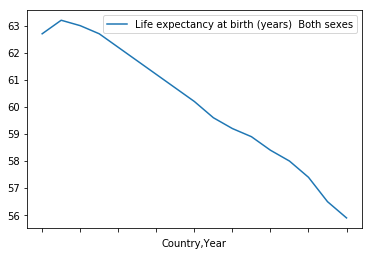

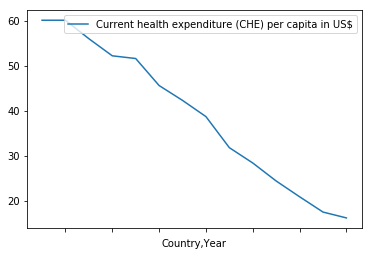

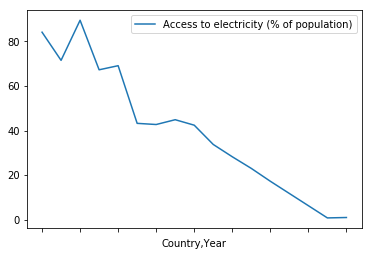

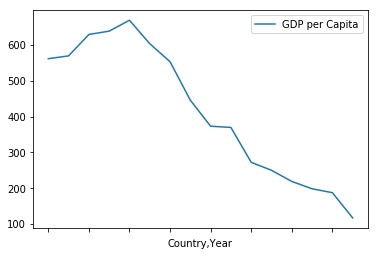

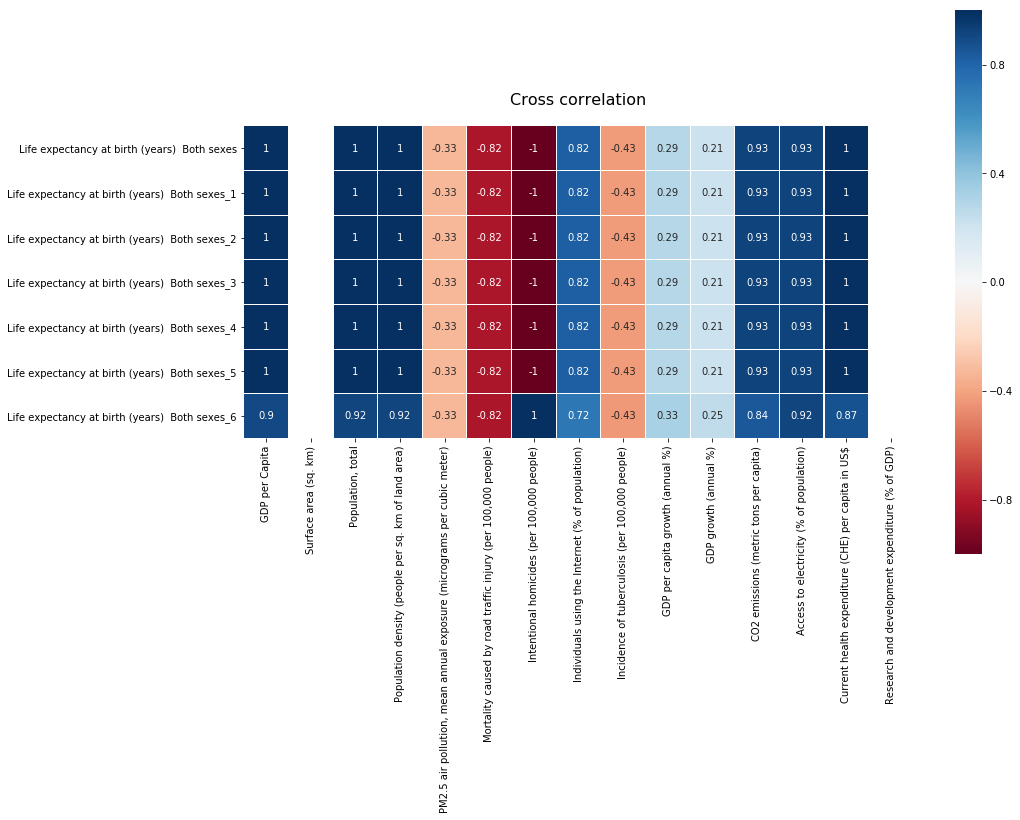

In [5]:
display(df_afghanistan[df_afghanistan.columns[[0]]].plot())
display(df_afghanistan[df_afghanistan.columns[[17]]].plot())
display(df_afghanistan[df_afghanistan.columns[[16]]].plot())
display(df_afghanistan[df_afghanistan.columns[[4]]].plot())
df_afg_corr = calculate_cross_correlation(df_afghanistan)
display(df_afg_corr.T)
display_cross_correlation(df_afg_corr)

# Let's have a look at the general picture:

Let's calculate for every country the correlations and retrive an overall summary.

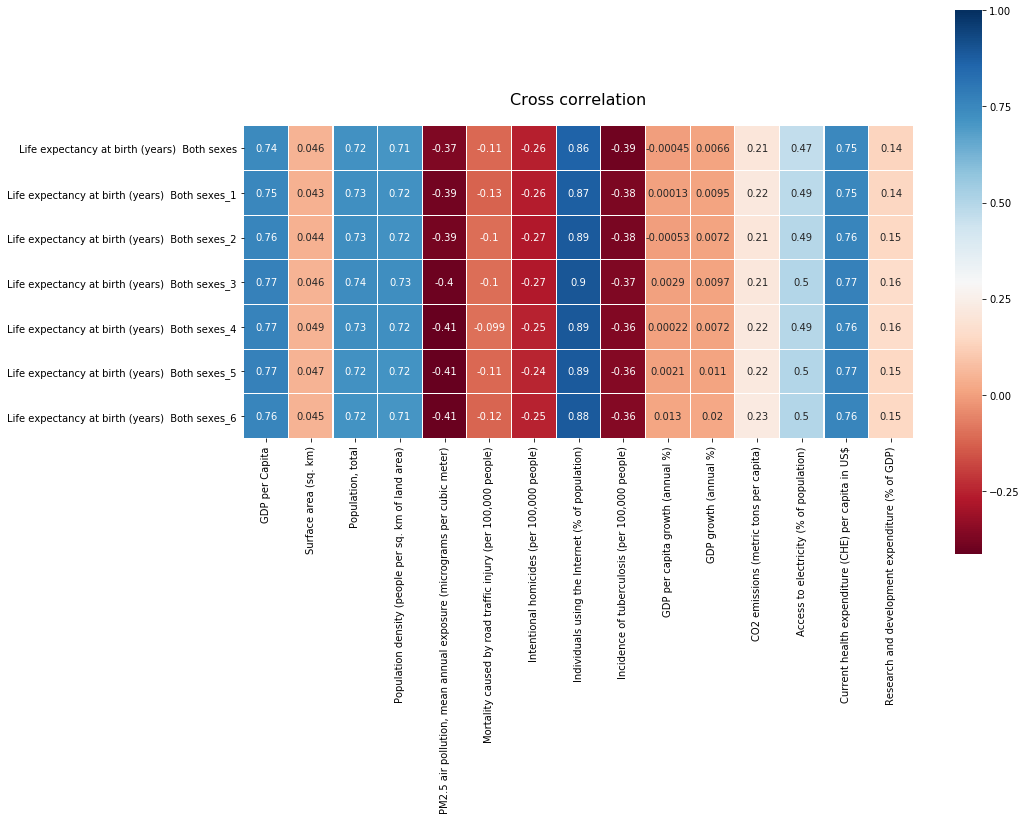

In [6]:

#initialise a df for every single feature with it's lagged life exp. 
#column_names = df_data.filter(regex='^(?!Life exp).*$',axis=1).columns.tolist()
df_accum_corr = None
count = 0
for index, country in df_data_country: 
    df_corr = calculate_cross_correlation(country)
    df_corr.fillna(0, inplace=True)
    count += 1
    if  df_accum_corr is None:
        df_accum_corr = df_corr
    else:
        df_accum_corr += df_corr
    
df_accum_corr = df_accum_corr/count
display_cross_correlation(df_accum_corr)



So just blindly calculating correlations and take good values as indicator for (higher) life. exp. is not a good idea. 
For example the CO2 emissions __positivly__ correlate with the life exp., but would not make sense. Since this is not good for human, it actually should decrease the life exp.. 

But since such values also correlate with GDP, which also correlates with life. exp. again, we can conclude that more money for industry also cars ect. could mean more money for health which again increase age. 

So it's actually life exp. and CO2 emission correlating with GDP but not with eachother. 

# Maybe look at some countries with the biggest variance in life exp if it's still the case